ok this all seems to work process-wise, but you need better training data. using gemini to generate the training data worked, but the problem of file names has screwed up the first attempt. should do it one image at a time so you can keep track of the names.

system prompt: You generate high-quality training data for image question and answering from scans of archaeological context sheets. It is important to work with highquality extracted text. The meaning of the texts in the scans can be deduced from which boxes the text was entered. Stratigraphic relationships can be inferred by the placement of context numbers in the rows of boxes; the present context will always be in the centre, and other contexts will be entered in stratigraphic relationship above or below as appropriate. Data should be returned in csv format: query, answer. Like so: What are the general easting and northing for this site?,"['443281.71','258449.217']". For each image provided, generate a dozen highquality questions and answers.



#### Step 1: Install libraries and dependencies.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q accelerate datasets peft bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!unzip archaepdfs.zip

Archive:  archaepdfs.zip
  inflating: split_images/document-page0.png  
  inflating: split_images/document-page10.png  
  inflating: split_images/document-page11.png  
  inflating: split_images/document-page12.png  
  inflating: split_images/document-page13.png  
  inflating: split_images/document-page14.png  
  inflating: split_images/document-page15.png  
  inflating: split_images/document-page16.png  
  inflating: split_images/document-page17.png  
  inflating: split_images/document-page1.png  
  inflating: split_images/document-page2.png  
  inflating: split_images/document-page3.png  
  inflating: split_images/document-page4.png  
  inflating: split_images/document-page5.png  
  inflating: split_images/document-page6.png  
  inflating: split_images/document-page7.png  
  inflating: split_images/document-page8.png  
  inflating: split_images/document-page9.png  


#### Step 2: Create Dataset (optional)

In [ ]:
# Clone repository.
!git clone https://github.com/NSTiwari/Fine-tune-IDEFICS-Vision-Language-Model.git

Cloning into 'Fine-tune-IDEFICS-Vision-Language-Model'...
remote: Enumerating objects: 718, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 718 (delta 6), reused 17 (delta 5), pack-reused 699
Receiving objects: 100% (718/718), 147.38 MiB | 33.38 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Updating files: 100% (1203/1203), done.


In [3]:
!mkdir test

In [30]:
from datasets import Dataset, DatasetDict, Image
import pandas as pd
import os

TRAIN_SAMPLES = 1000
TEST_SAMPLES = 200
TEST_SIZE = 0.166

# Define the directory containing the images.
train_images_directory = '/content/train/'
test_images_directory = '/content/test/'

# Read the CSV Q&A text.
qa_text = pd.read_csv('/content/qa_text.csv')

# Get the list of ids from the csv, which we'll use to match filenames
ids_from_csv = qa_text['id'].tolist()

print(ids_from_csv)

# Create a mapping between ids from csv and filenames
image_paths = []
for file_id in ids_from_csv:
    # Try to find the image in the training directory.
    image_path = os.path.join(train_images_directory, f'{file_id}.png')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        continue #move on to next id
    # if it's not found in the training directory, check the test directory
    image_path = os.path.join(test_images_directory, f'{file_id}.png')
    if os.path.exists(image_path):
        image_paths.append(image_path)
        continue #move on to next id
    # Special case: check for summary.png in training directory
    if file_id == "summary":
         image_path = os.path.join(train_images_directory, f'summary.png')
         if os.path.exists(image_path):
            image_paths.append(image_path)
            continue #move on to next id
    # If none of the above, raise error
    raise ValueError(f"Could not find a relevant image file for {file_id} from csv id")

# Create a list of other columns such as id, query, and answer.
ids = ids_from_csv
queries = qa_text['query'].tolist()
answers = qa_text['answers'].tolist()

# Create the dataset dictionary
dataset_dict = {
    'id': ids,
    'image': image_paths,
    'query': queries,
    'answers': answers
}

# Create the dataset.
dataset = Dataset.from_dict(dataset_dict)

# Cast the 'image' column to Image type.
dataset = dataset.cast_column("image", Image())

# Split the dataset into train and test.
split_dataset = dataset.train_test_split(test_size=TEST_SIZE, shuffle=False)

print(split_dataset)



['document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page0', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page1', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page2', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page3', 'document-page4', 'document-page4', 'document-page4', 'document-page4', 'document-page4', 'document

#### Step 3: Push the dataset on Hugging Face Hub (optional)

In [16]:
from huggingface_hub import notebook_login
notebook_login()

In [31]:
split_dataset.push_to_hub("sgraham/DocumentIDEFICS_QA_archae_test")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/sgraham/DocumentIDEFICS_QA_archae_test/commit/e586e2eb65981e4de55732289c7b12a4446a0905', commit_message='Upload dataset', commit_description='', oid='e586e2eb65981e4de55732289c7b12a4446a0905', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/sgraham/DocumentIDEFICS_QA_archae_test', endpoint='https://huggingface.co', repo_type='dataset', repo_id='sgraham/DocumentIDEFICS_QA_archae_test'), pr_revision=None, pr_num=None)

#### Step 4: Load the dataset

In [32]:
from datasets import load_dataset

train_dataset = load_dataset("sgraham/DocumentIDEFICS_QA_archae_test", split="train")
eval_dataset = load_dataset("sgraham/DocumentIDEFICS_QA_archae_test", split="test")

README.md:   0%|          | 0.00/479 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/306k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/23 [00:00<?, ? examples/s]

Inspect the training data

In [19]:
train_dataset[0]

{'id': 'document-page0',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1656x2338>,
 'query': 'What is the site code?',
 'answers': '["1020 LOW TT"]'}

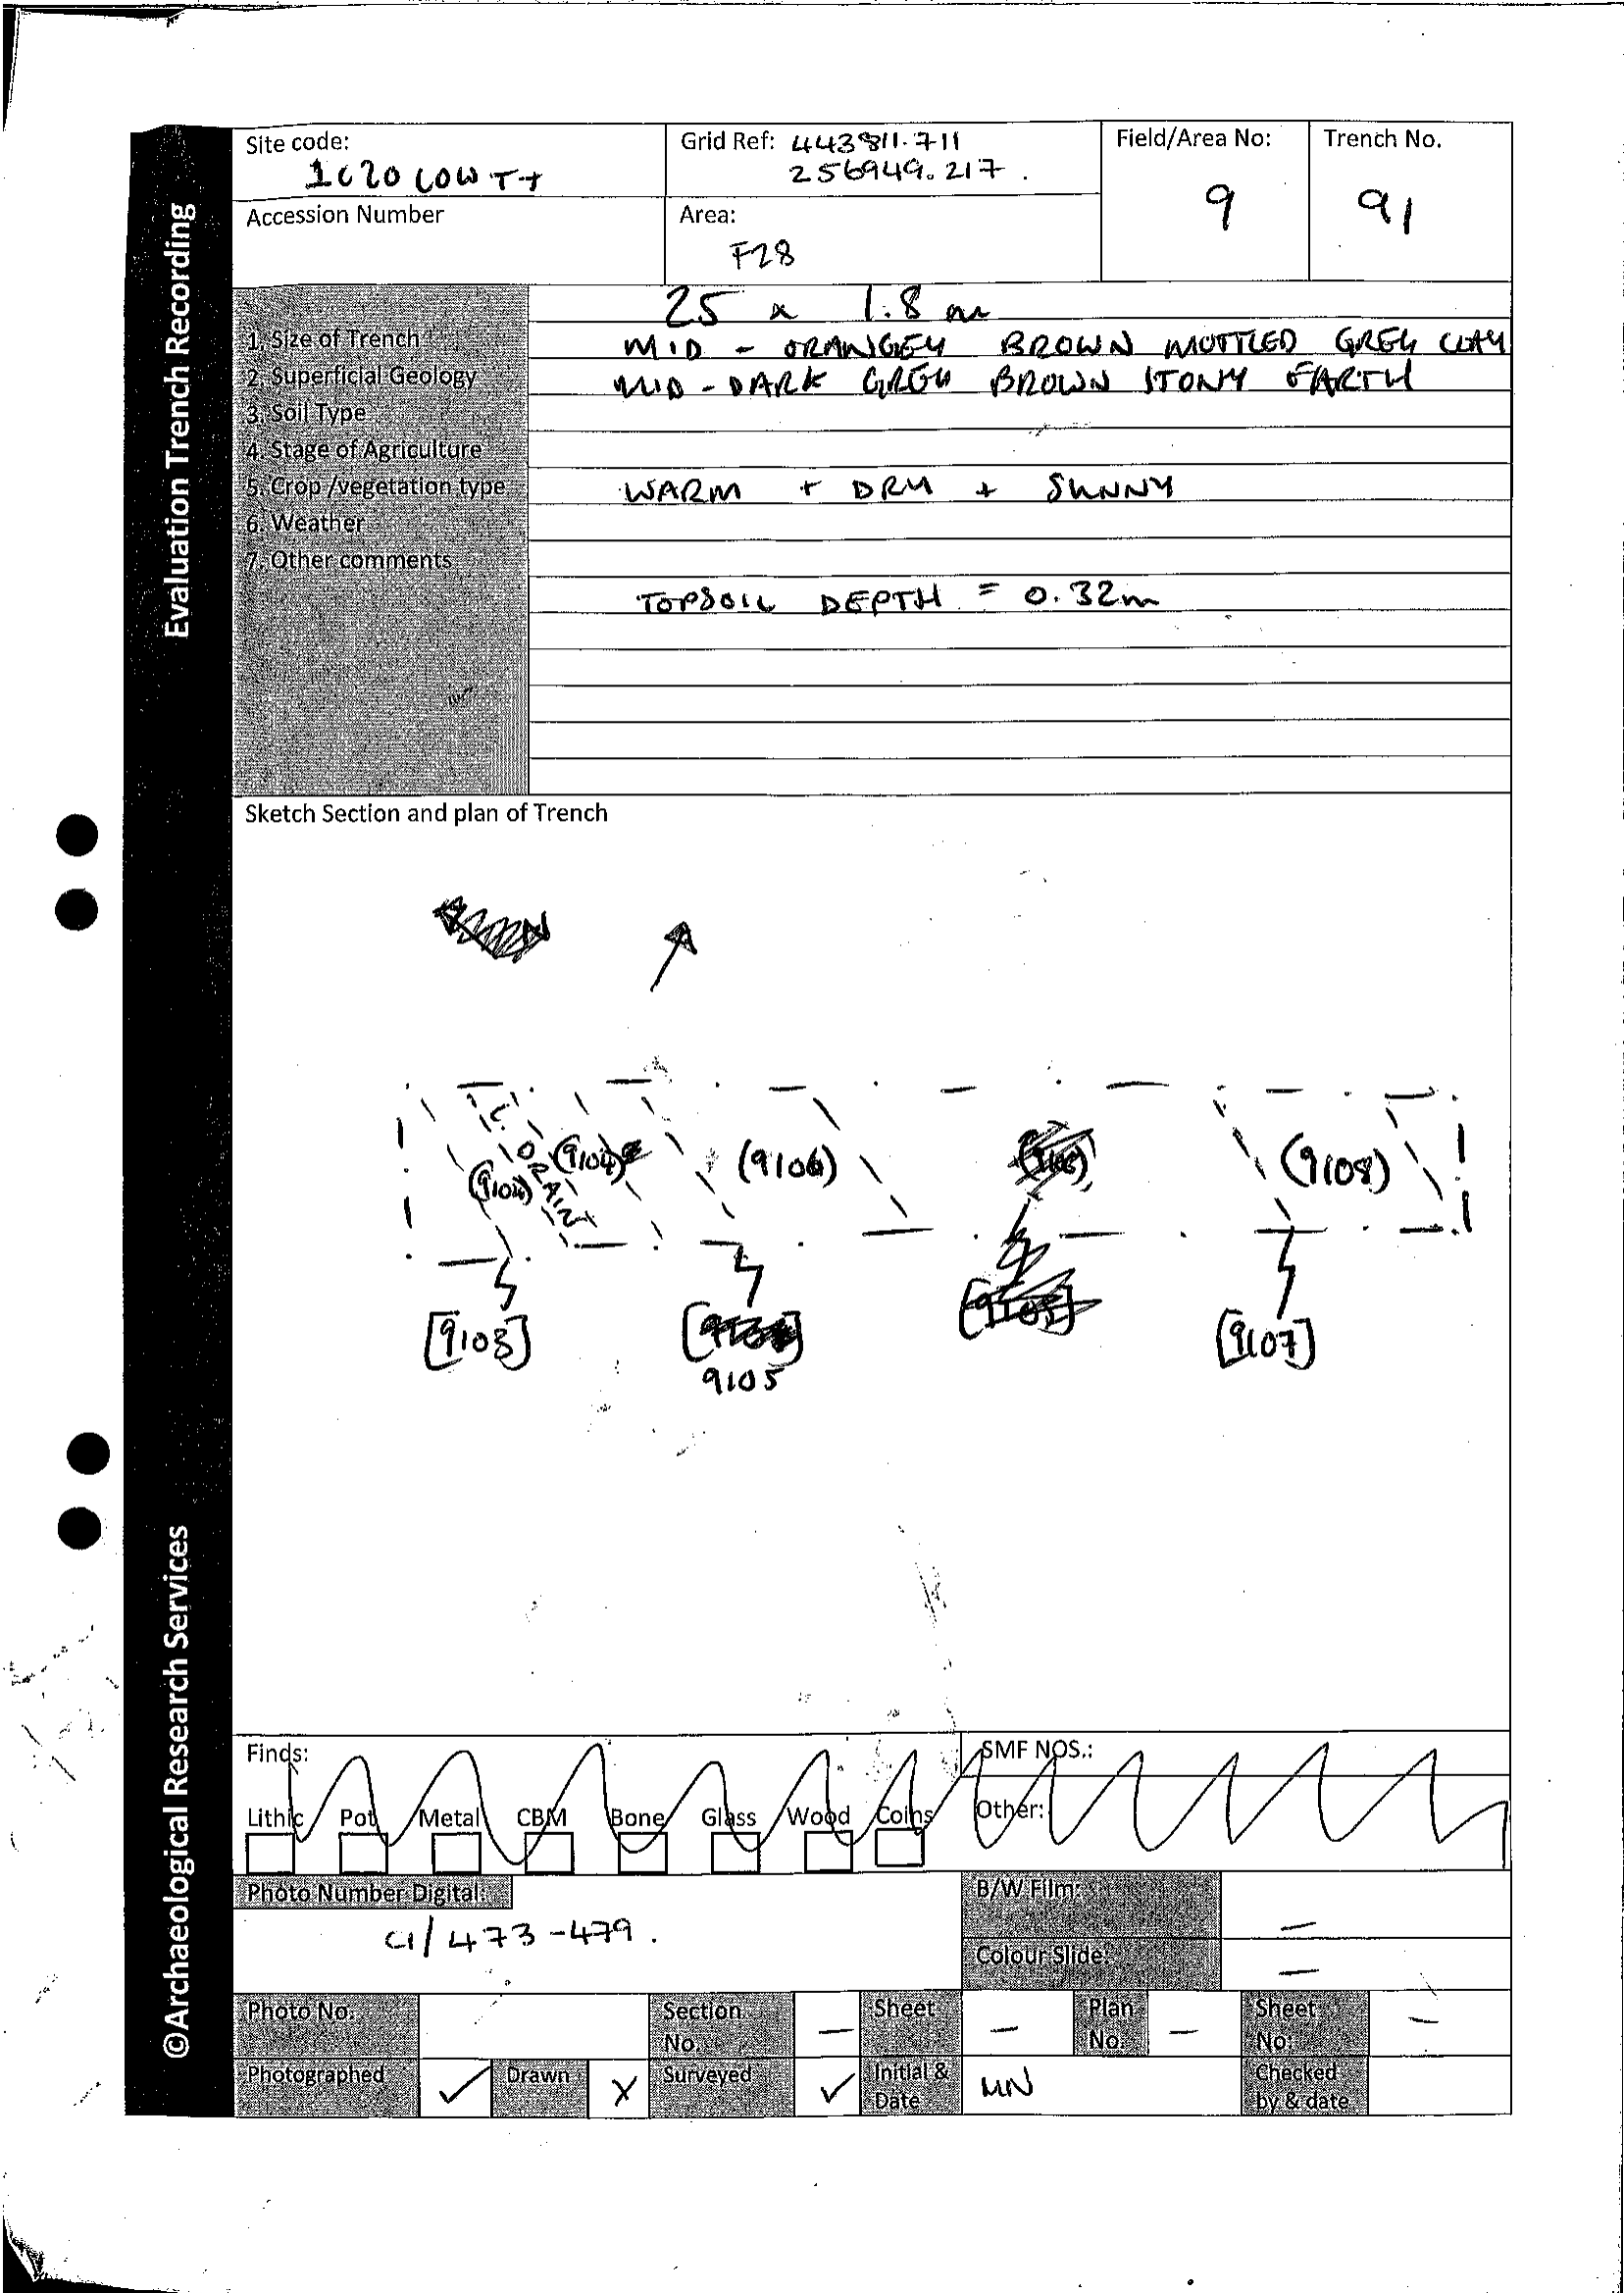

In [20]:
train_dataset[0]['image']

#### Step 5: Configure LoRA adapters

In [2]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True

processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)

Chat templates should be in a 'chat_template.jinja' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


In [6]:
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # This works for A100 or H100
    ).to(DEVICE)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

#### Step 6: Create Data Collator for IDEFICS2 format.

In [38]:
import random
import ast

class MyDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, examples):
        texts = []
        images = []
        for example in examples:
            image = example["image"].convert("RGB") # my images are greyscale
            question = example["query"]
            # Check if the answer is already a list or needs to be converted
            answer = example["answers"]
            # if the answer is an integer, wrap it in a list to make random.choice work
            if isinstance(answer, int):
                answer = [answer]
            elif isinstance(answer, str):
                answer = ast.literal_eval(answer)
            if not isinstance(answer, list):
                answer = [answer] # handles the case where answer is a single int or str

            #Now the answer should always be a list
            answer = random.choice(answer)

            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(
                messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images,
                          return_tensors="pt", padding=True)
        labels = batch.input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        labels[labels == model.config.image_token_id] = -100
        batch["labels"] = labels
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        return batch

data_collator = MyDataCollator(processor)

#### Step 7: Setup training parameters

In [22]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = "IDEFICS_DocVQA_1",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    evaluation_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 10,
    save_steps = 25,
    max_steps = 25,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

# training_args = TrainingArguments(
#     output_dir="IDEFICS3_DocVQA",
#     learning_rate=2e-4,
#     fp16=True,
#     per_device_train_batch_size=3,
#     per_device_eval_batch_size=3,
#     gradient_accumulation_steps=8,
#     dataloader_pin_memory=False,
#     save_total_limit=3,
#     evaluation_strategy="steps",
#     save_strategy="steps",
#     eval_steps=25,
#     save_steps=25,
#     max_steps=1000,
#     logging_steps=5,
#     remove_unused_columns=False,
#     push_to_hub=False,
#     label_names=["labels"],
#     load_best_model_at_end=True,
#     report_to="none",
#     optim="paged_adamw_8bit",
# )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1573: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset
)

#### Step 8: Start Training

In [41]:
trainer.train()

Step,Training Loss,Validation Loss
10,2.094800,0.671212
20,1.399900,0.553137


TrainOutput(global_step=25, training_loss=2.214905891418457, metrics={'train_runtime': 657.6668, 'train_samples_per_second': 0.608, 'train_steps_per_second': 0.038, 'total_flos': 1666311723127392.0, 'train_loss': 2.214905891418457, 'epoch': 3.1403508771929824})

#### Step 9: Evaluate the model

In [42]:
!mkdir test

mkdir: cannot create directory ‘test’: File exists


In [50]:
eval_dataset

Dataset({
    features: ['id', 'image', 'query', 'answers'],
    num_rows: 23
})

In [63]:
test_example = eval_dataset[0]
test_example

{'id': 'document-page9',
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1656x2338>,
 'query': 'What is the site name?',
 'answers': "['Lower Radbourne']"}

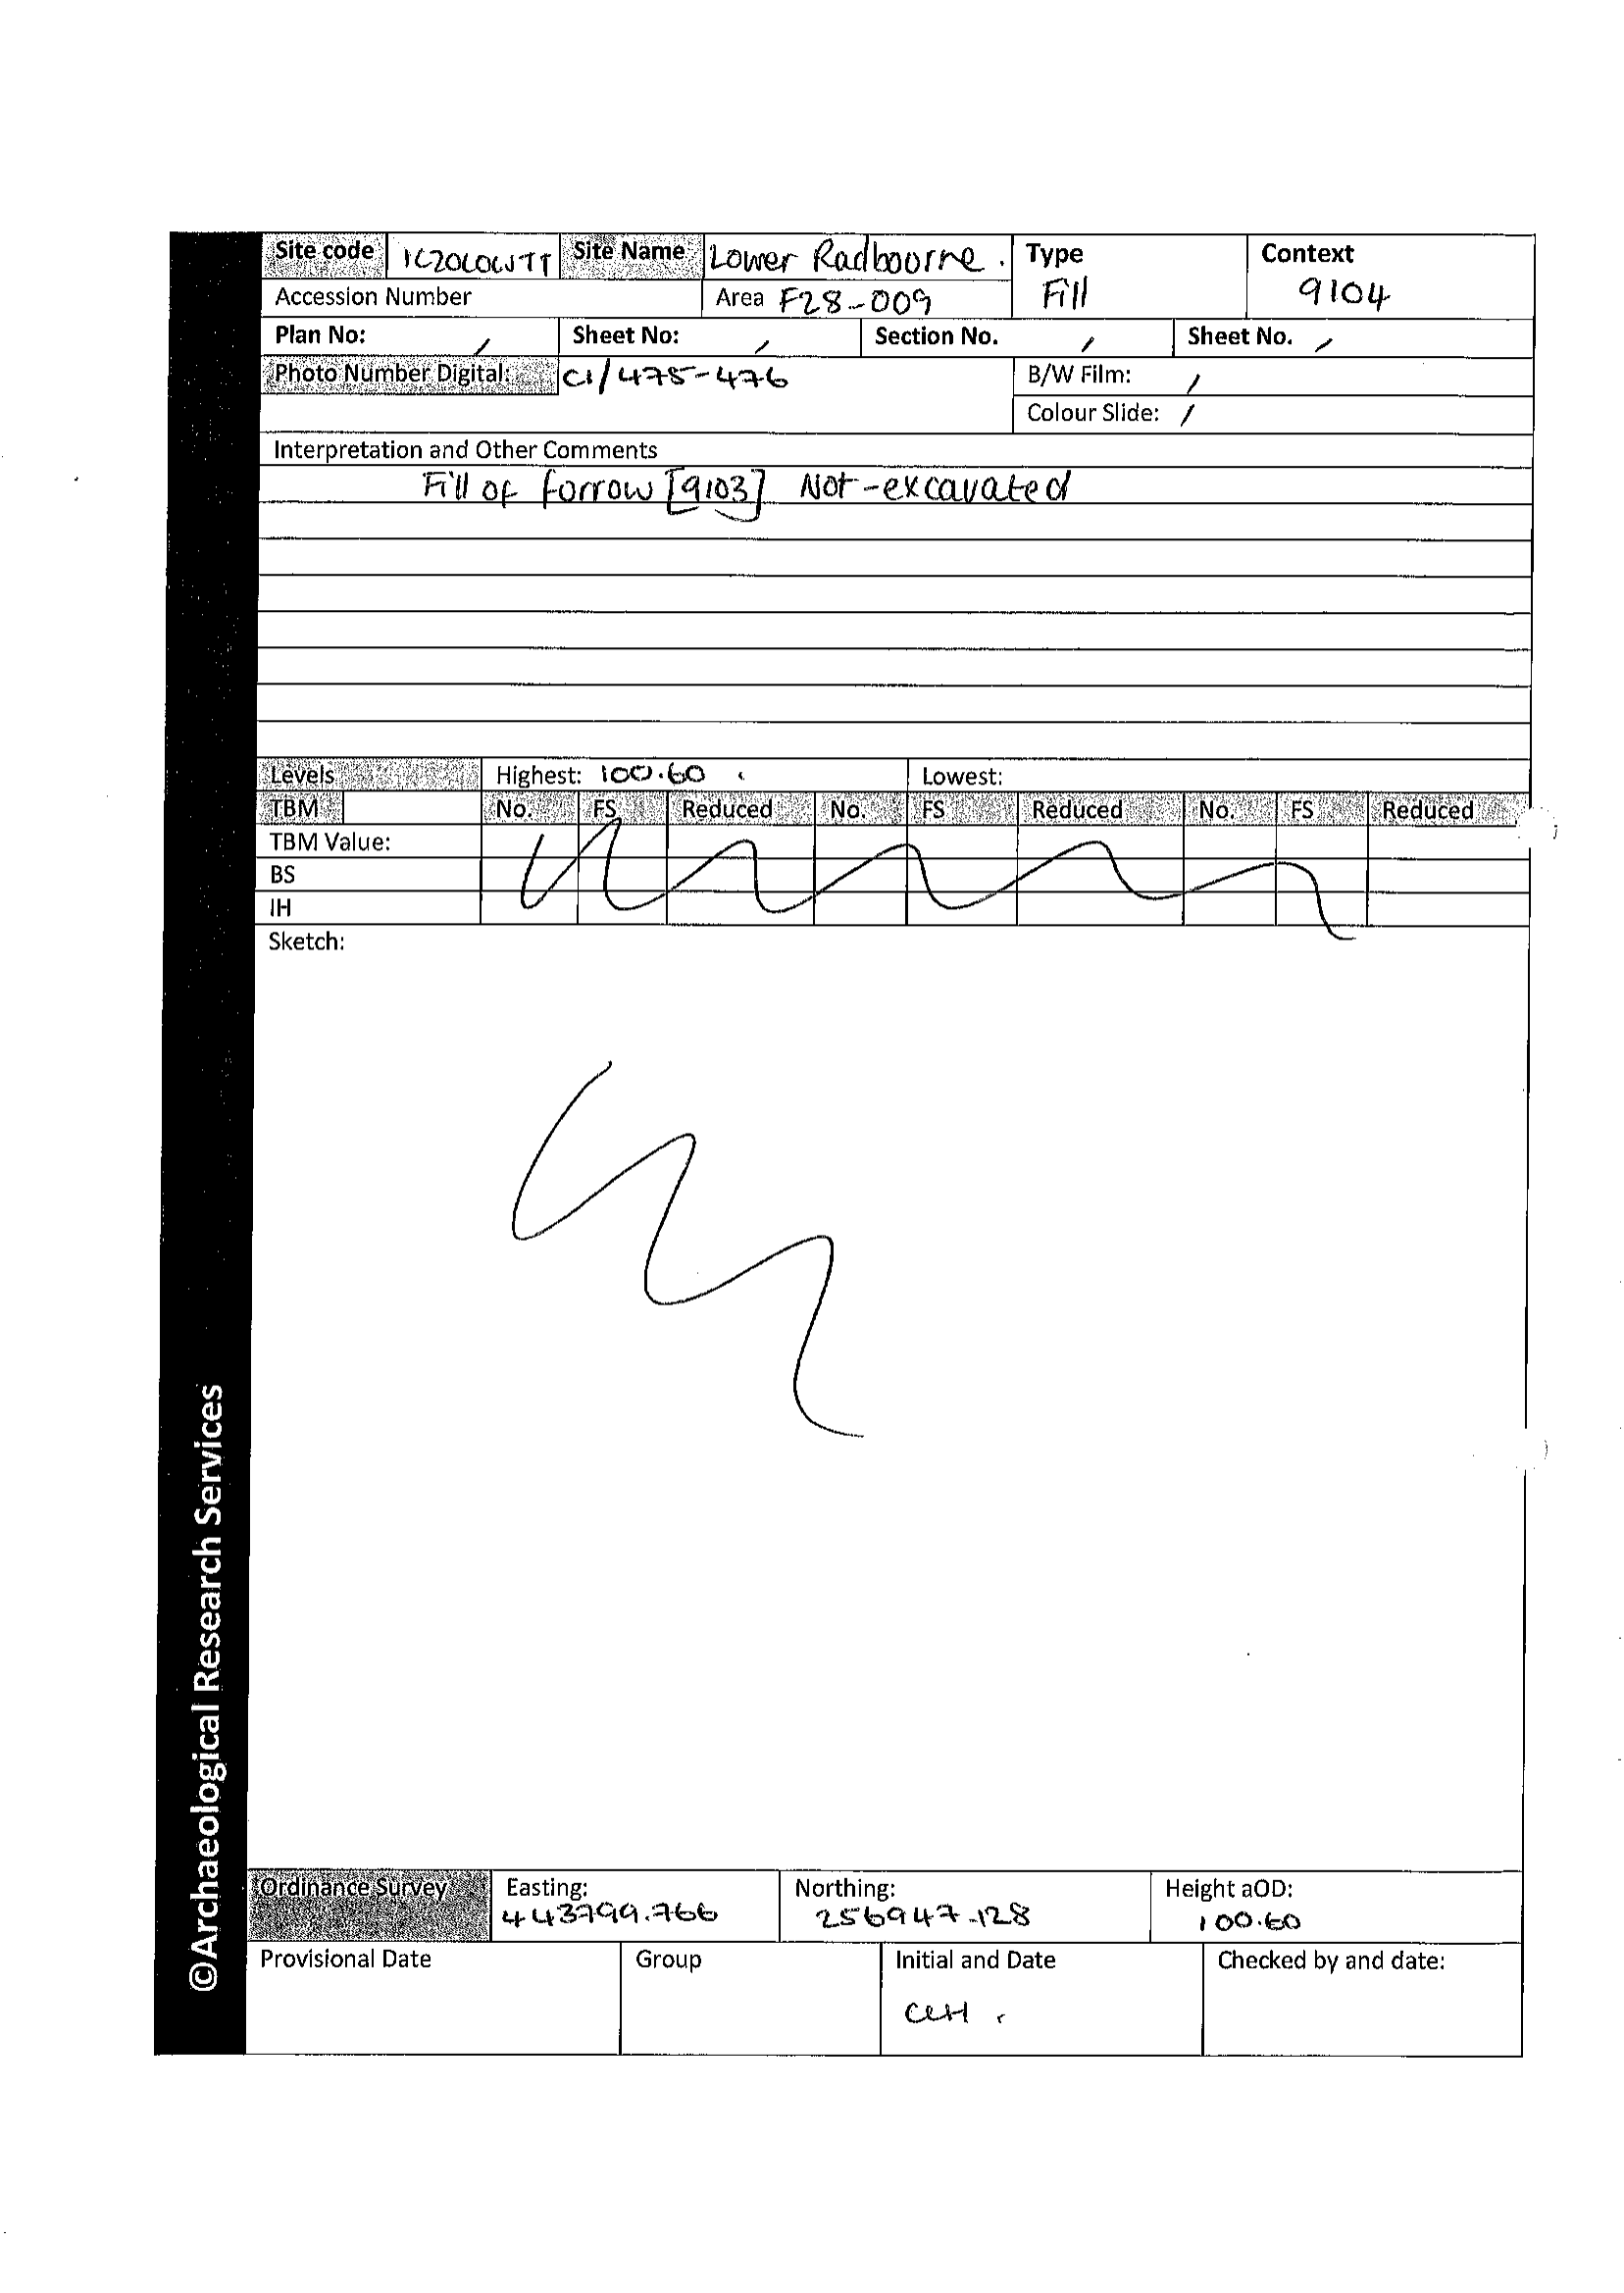

In [64]:
test_example["image"]

In [59]:
model.eval()

image = test_example["image"]
query = test_example["query"]
print(query)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Give your best answer."},
            {"type": "image"},
            {"type": "text", "text": query}
        ]
    }
]


text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True)

# Move inputs to the same device as the model
inputs = inputs.to(DEVICE)  # This line is added

generated_ids = model.generate(**inputs, max_new_tokens=64)
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
print(generated_texts)

What is the stratigraphic relationship of context 9105?
['Below 9106']


#### Step 10: Push the model on Hugging Face

In [ ]:
from huggingface_hub import whoami
from pathlib import Path

# Output directory.
output_dir = "IDEFICS_DocVQA_1"
repo_name = "IDEFICS2-DocVQA-fine-tuned"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{repo_name}"

In [ ]:
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id


upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="Pushed the IDEFICS2 fine-tuned model.",
    ignore_patterns=["step_*", "epoch_*"],
)

adapter_model.safetensors:   0%|          | 0.00/93.4M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NSTiwari/IDEFICS2-DocVQA-fine-tuned/commit/079b8cb454138e87809ffeee6f14108407ced13c', commit_message='Pushed the IDEFICS2 fine-tuned model.', commit_description='', oid='079b8cb454138e87809ffeee6f14108407ced13c', pr_url=None, pr_revision=None, pr_num=None)